# 目的
Kerasを用いた為替の予測をもう少し進める。   
`Test of Keras 2`の方で、勝率が高いと考えていたが、実はラベリングにミスがあるということに気づいた。  
たしかに時刻 $t+\tau$ で下がるか上がるかという情報を $t+\tau$ で渡していれば、確率も上がるのは当然だろう。   

このノートでは、修正されたラベリングを用いて、再度モデルと学習データを検討する。

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import os
import pickle
import pandas as pd
import numpy as np
import datetime

from FX.FX import SQLAnaforFX
from FX.FX import drawfigfunc as dff
from FX.FX import datetimefuncs as dtf
from FX.FX import analyzefuncs as af
from FX.FX import KerasModelAdapter

Using TensorFlow backend.


## データの用意

In [2]:
"""DBの読み込み"""
dbpath = "201704"
sql = SQLAnaforFX(dbpath)
sql.showtablenames()

"""OHLC"""
close = sql.toDataFrame("ask01min", colselect=["close"]).as_matrix()[:,0]
opens = sql.toDataFrame("ask01min", colselect=["open"]).as_matrix()[:,0]
high = sql.toDataFrame("ask01min", colselect=["high"]).as_matrix()[:,0]
low = sql.toDataFrame("ask01min", colselect=["low"]).as_matrix()[:,0]
ohlc = np.vstack((opens, high, low, close))
oc = np.vstack((opens, close)).T

dclose = np.zeros_like(close)
dclose[1:] = np.diff(close)

"""Spread"""
close_bid = sql.toDataFrame("bid01min", colselect=["close"]).as_matrix()[:,0]
s = np.mean((close - close_bid)[close != 0])
close_ask = close_bid + s
ask_bid = np.vstack((close_ask, close_bid)).T

"""SMA"""
sma = sql.toDataFrame("ask01min", colselect=["sma07", "sma13", "sma25"]).as_matrix()
sma = sma.T

## SMAを利用する場合、データの最初から数えてSMAの最大スパンまでのデータは利用しない方がよさそう。
sma_max_span = 25

"""Datetime"""
_ = sql.toDataFrame("ask01min", colselect=["sma07"])
dtformat = "%Y-%m-%d %H:%M:%S"
datetimes = list(_.index)
datetimes = [datetime.datetime.strptime(datetimes[ii], dtformat) for ii in range(len(datetimes))]
datetimes = np.array([(datetimes[ii] - datetimes[0]).total_seconds()/60.**2 for ii in range(len(datetimes))])

In [3]:
len(sql.toDataFrame())

322762

In [4]:
len(sql.toDataFrame())/len(close)

12.120695482368847

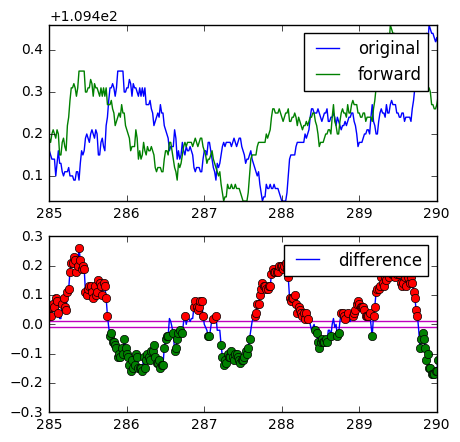

In [5]:
y, diff = af.labeling(close, 2*s, 30, 2)

xlim = [285, 290]

dff.makefig(5,5)
plt.subplot(211)
plt.plot(datetimes, close, label="original")

close_forward = np.zeros_like(close)
close_forward[:-30] = close[30:]
plt.plot(datetimes, close_forward, label="forward")
ind = (datetimes>= xlim[0])&(datetimes <= xlim[1])
plt.xlim(xlim)
plt.ylim([close[ind].min(), close[ind].max()])
plt.legend()

plt.subplot(212)
plt.plot(datetimes, diff, label="difference")
plt.plot(datetimes[y[:, 0]== 1], diff[y[:, 0]== 1], "ro")
plt.plot(datetimes[y[:, 2]== 1], diff[y[:, 2]== 1], "go")
plt.hlines([-0.01, 0.01], datetimes[0], datetimes[-1], color="m")
plt.xlim(xlim)
plt.ylim(-0.3, 0.3)
plt.legend()


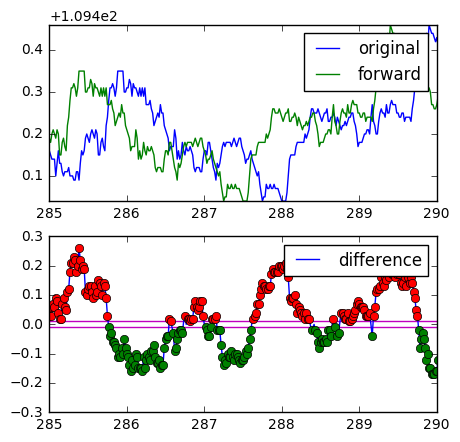

In [6]:
y, diff = af.labeling(close, s, 30, 2)

xlim = [285, 290]

dff.makefig(5,5)
plt.subplot(211)
plt.plot(datetimes, close, label="original")

close_forward = np.zeros_like(close)
close_forward[:-30] = close[30:]
plt.plot(datetimes, close_forward, label="forward")
ind = (datetimes>= xlim[0])&(datetimes <= xlim[1])
plt.xlim(xlim)
plt.ylim([close[ind].min(), close[ind].max()])
plt.legend()

plt.subplot(212)
plt.plot(datetimes, diff, label="difference")
plt.plot(datetimes[y[:, 0]== 1], diff[y[:, 0]== 1], "ro")
plt.plot(datetimes[y[:, 2]== 1], diff[y[:, 2]== 1], "go")
plt.hlines([-0.01, 0.01], datetimes[0], datetimes[-1], color="m")
plt.xlim(xlim)
plt.ylim(-0.3, 0.3)
plt.legend()


# closeのみ

In [7]:
def create_model(X, y):
    model = Sequential()
    
    # 入力層
    model.add(Dense(256, input_shape=(X.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 中間層
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 出力層
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))

    # コンパイル
    model.compile(loss='categorical_crossentropy',
        optimizer="rmsprop",
        metrics=['accuracy'])
    
    return model

In [12]:
y, diff = af.labeling(close, s, 30, 2)

close_norm = close - close.mean()
X = close_norm / np.abs(close_norm).max()
X_train, X_test, y_train, y_test = train_test_split(X[:, None], y, test_size=0.3, random_state=90)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = create_model(X[:, None], y)

(18640, 1) (7989, 1) (18640, 3) (7989, 3)


In [13]:
diff, y

(array([ 0.04,  0.03, -0.04, ...,  0.  ,  0.  ,  0.  ]),
 array([[ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        ..., 
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.]]))

In [14]:
# データで訓練 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=400,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=0)

# テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.963811579284
accuracy= 0.467392664989


## もし高確率で予測されるもののみを取り出したら、正解率はどうなる？

まずは確率のヒストグラムをとる。

In [15]:
"""確率の取得"""
probs = model.predict_proba(X_test, verbose=0).T
labels = ["high", "lose", "low"]

"""確率のヒストグラムの作成"""
xbins = np.arange(0, 1.0, 0.05)
hists = np.zeros((3, len(xbins)))
for ii in range(len(probs)):
    hists[ii, :-1], bins = np.histogram(probs[ii], bins=xbins)
    hists[ii] /= hists[ii].sum()

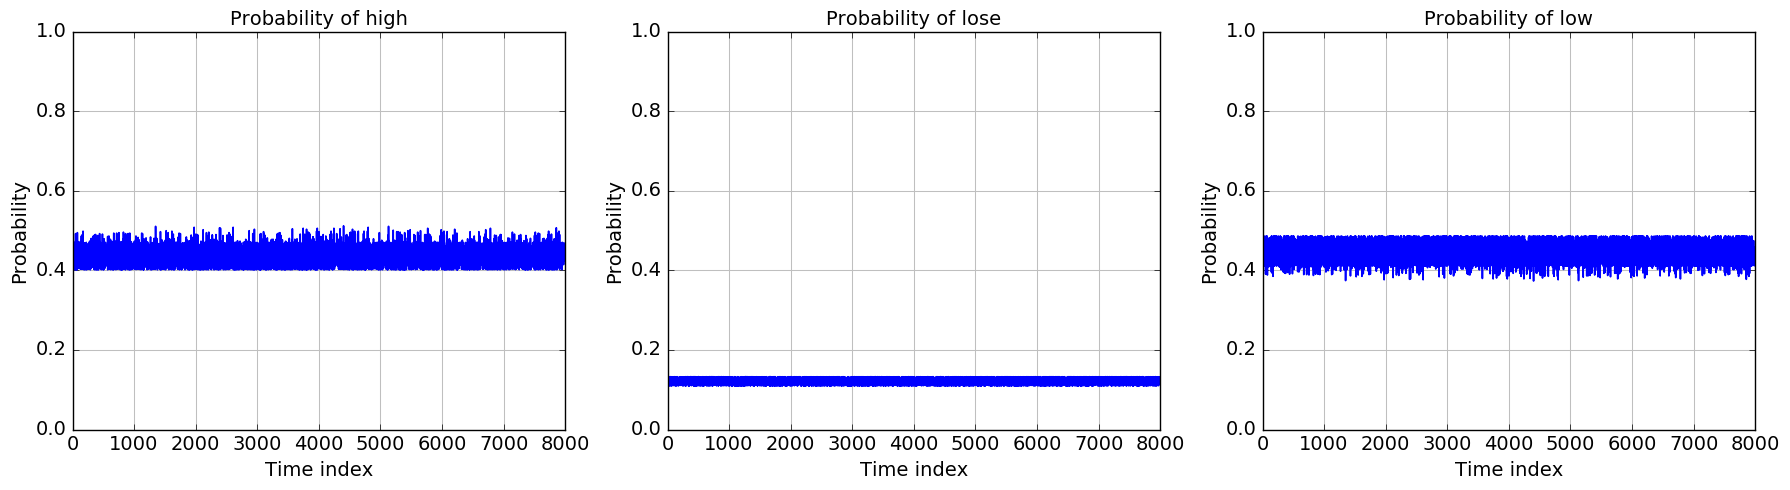

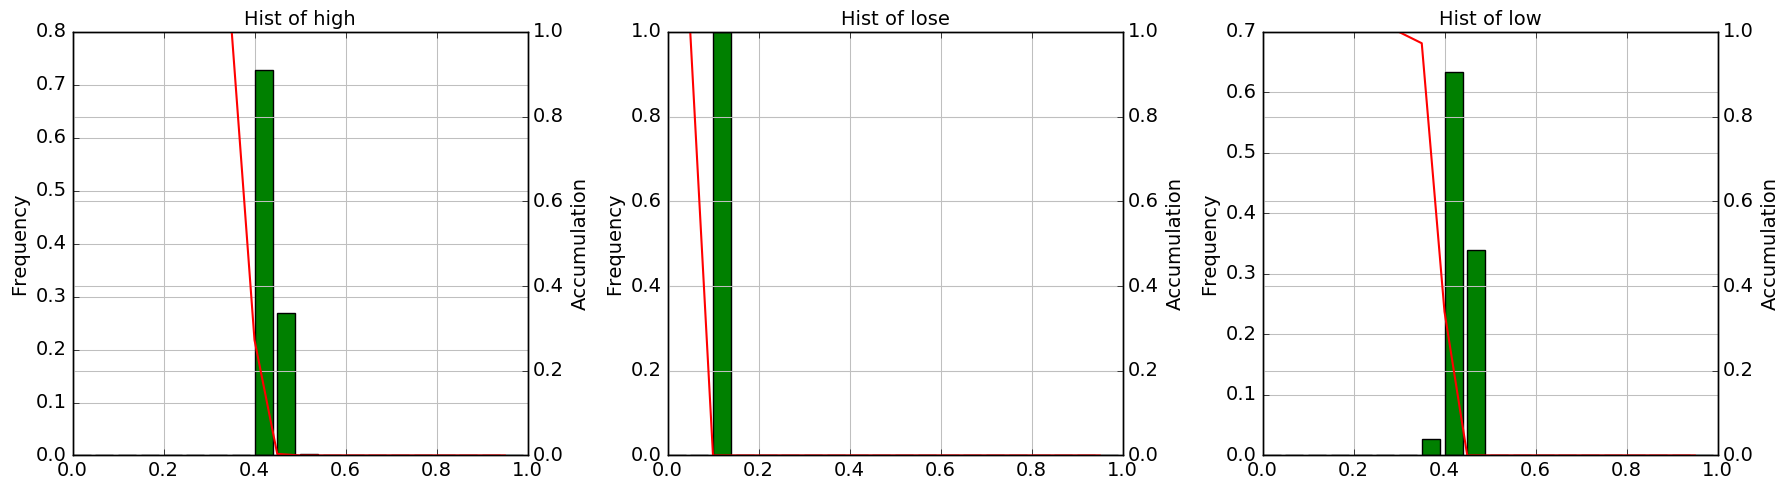

In [16]:
# 各ラベルに該当する確率
dff.makefig(18, 5)
for ii in range(len(probs)):
    plt.subplot(1,3,ii + 1)
    plt.plot(probs[ii], linewidth=1.2)
    dff.arrangefig(xlabel="Time index", ylabel="Probability", title="Probability of {}".format(labels[ii]))
    plt.ylim(0, 1)
plt.tight_layout()

# 各ラベルに該当する確率のヒストグラム
dff.makefig(18, 5)
dxbins = np.diff(xbins)[0]
for ii in range(len(hists)):
    plt.subplot(1,3,ii + 1)
    plt.bar(xbins, hists[ii], width=0.8*dxbins, hold="center", color="g")
    dff.arrangefig(ylabel="Frequency")
    ax2 = plt.gca().twinx()
    ax2.plot(xbins, 1.0 - np.cumsum(hists[ii]), "r-", linewidth=1.5)
    dff.arrangefig(xlabel="Probability", ylabel="Accumulation", title="Hist of {}".format(labels[ii]))
    plt.ylim(0, 1)
#     plt.yscale("log")
plt.tight_layout()

とりあえず60%以上を対象にするか。

In [27]:
prob_threshold = 0.6
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), ",total:", ind_sum.sum())

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [ 0  0 47] ,total: 47
loss= 0.668313670666
accuracy= 0.787234046358


# SMAを利用した場合

In [17]:
def create_model(X, y):
    model = Sequential()
    
    # 入力層
    model.add(Dense(256, input_shape=(X.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 中間層
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 出力層
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))

    # コンパイル
    model.compile(loss='categorical_crossentropy',
        optimizer="rmsprop",
        metrics=['accuracy'])
    
    return model

In [18]:
y, diff = af.labeling(close, 2*s, 30, 2)
y = y[sma_max_span:]

sma_mean = sma[:, sma_max_span:].mean(axis=1)
sma_norm = np.zeros_like(sma[:, sma_max_span:])
for ii in range(sma.shape[0]):
    sma_norm[ii] = sma[ii, sma_max_span:] - sma_mean[ii]
    sma_norm[ii] /= np.abs(sma_norm[ii]).max()

X = sma_norm.T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = create_model(X, y)

(18622, 3) (7982, 3) (18622, 3) (7982, 3)


In [19]:
# データで訓練 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=160, shuffle=False,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=0)

# テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 1.08222400031
accuracy= 0.403031821621


## こちらでも高確率のもののみを取り出す

In [20]:
"""確率の取得"""
probs = model.predict_proba(X_test, verbose=0).T
labels = ["high", "lose", "low"]

"""確率のヒストグラムの作成"""
xbins = np.arange(0, 1.0, 0.05)
hists = np.zeros((3, len(xbins)))
for ii in range(len(probs)):
    hists[ii, :-1], bins = np.histogram(probs[ii], bins=xbins)
    hists[ii] /= hists[ii].sum()

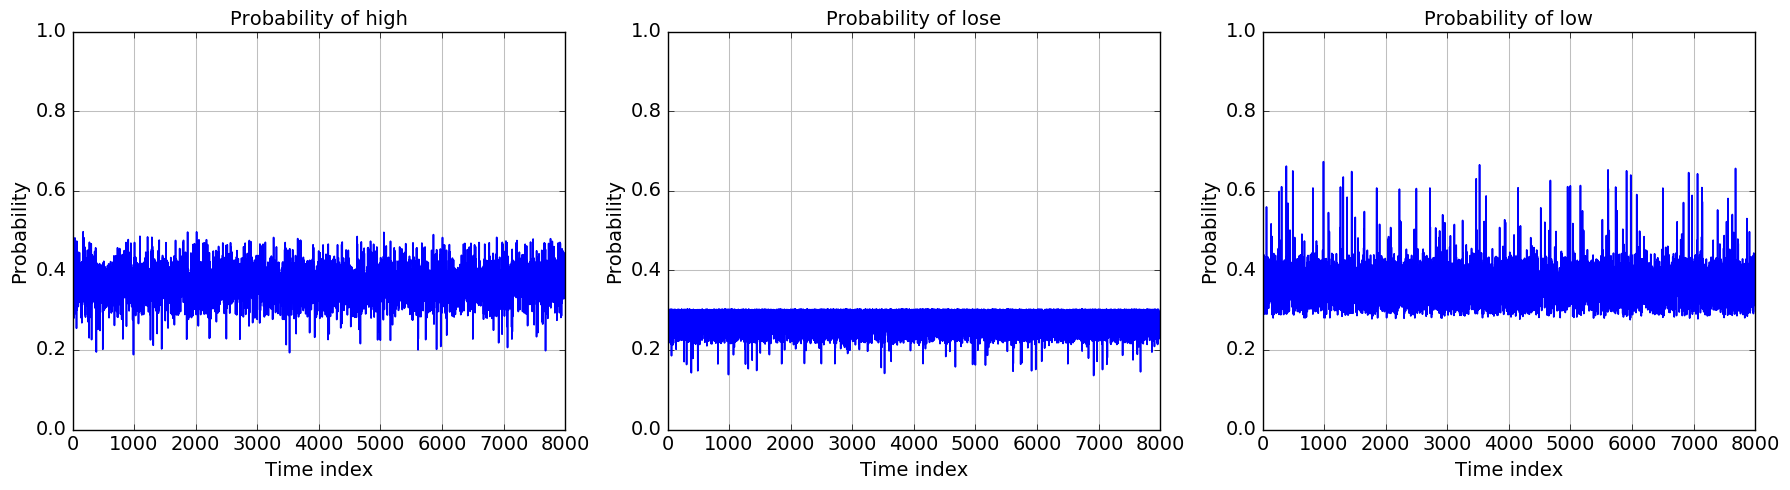

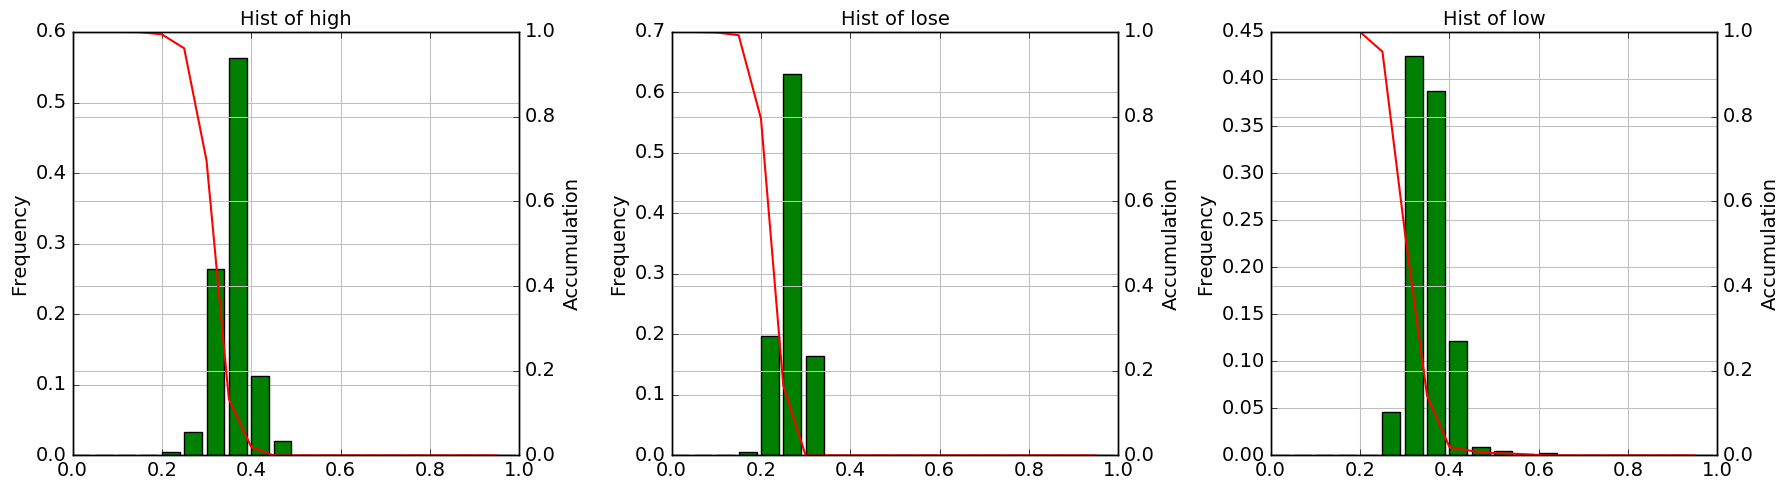

In [21]:
# 各ラベルに該当する確率
dff.makefig(18, 5)
for ii in range(len(probs)):
    plt.subplot(1,3,ii + 1)
    plt.plot(probs[ii], linewidth=1.2)
    dff.arrangefig(xlabel="Time index", ylabel="Probability", title="Probability of {}".format(labels[ii]))
    plt.ylim(0, 1)
plt.tight_layout()

# 各ラベルに該当する確率のヒストグラム
dff.makefig(18, 5)
dxbins = np.diff(xbins)[0]
for ii in range(len(hists)):
    plt.subplot(1,3,ii + 1)
    plt.bar(xbins, hists[ii], width=0.8*dxbins, hold="center", color="g")
    dff.arrangefig(ylabel="Frequency")
    ax2 = plt.gca().twinx()
    ax2.plot(xbins, 1.0 - np.cumsum(hists[ii]), "r-", linewidth=1.5)
    dff.arrangefig(xlabel="Probability", ylabel="Accumulation", title="Hist of {}".format(labels[ii]))
    plt.ylim(0, 1)
#     plt.yscale("log")
plt.tight_layout()

In [41]:
prob_threshold = 0.6
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X_test)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [ 0  0 36] ,total: 36 , percentage:0.5
loss= 0.601861933867
accuracy= 0.916666666667


closeだけの場合と比べて下がっている？

# HLも加える
Openとcloseは等価であり、またSMAもcloseとほぼ等価である。   
ここではSMAにHigh/Lowを加えてみる。

In [69]:
y, diff = af.labeling(close, 2*s, 30, 2)
y = y[sma_max_span:]

hlsma = np.vstack((high, low, sma))
hlsma_mean = hlsma[:, sma_max_span:].mean(axis=1)
hlsma_norm = np.zeros_like(hlsma[:, sma_max_span:])
for ii in range(hlsma.shape[0]):
    hlsma_norm[ii] = hlsma[ii, sma_max_span:] - hlsma_mean[ii]
    hlsma_norm[ii] /= np.abs(hlsma_norm[ii]).max()

X = hlsma_norm.T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = create_model(X, y)

(18622, 5) (7982, 5) (18622, 3) (7982, 3)


In [75]:
# データで訓練 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=800, shuffle=False,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=0)

# テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 1.08184827673
accuracy= 0.396141317988


## こちらでも高確率のもののみを取り出す

In [76]:
"""確率の取得"""
probs = model.predict_proba(X_test, verbose=0).T
labels = ["high", "lose", "low"]

"""確率のヒストグラムの作成"""
xbins = np.arange(0, 1.0, 0.05)
hists = np.zeros((3, len(xbins)))
for ii in range(len(probs)):
    hists[ii, :-1], bins = np.histogram(probs[ii], bins=xbins)
    hists[ii] /= hists[ii].sum()

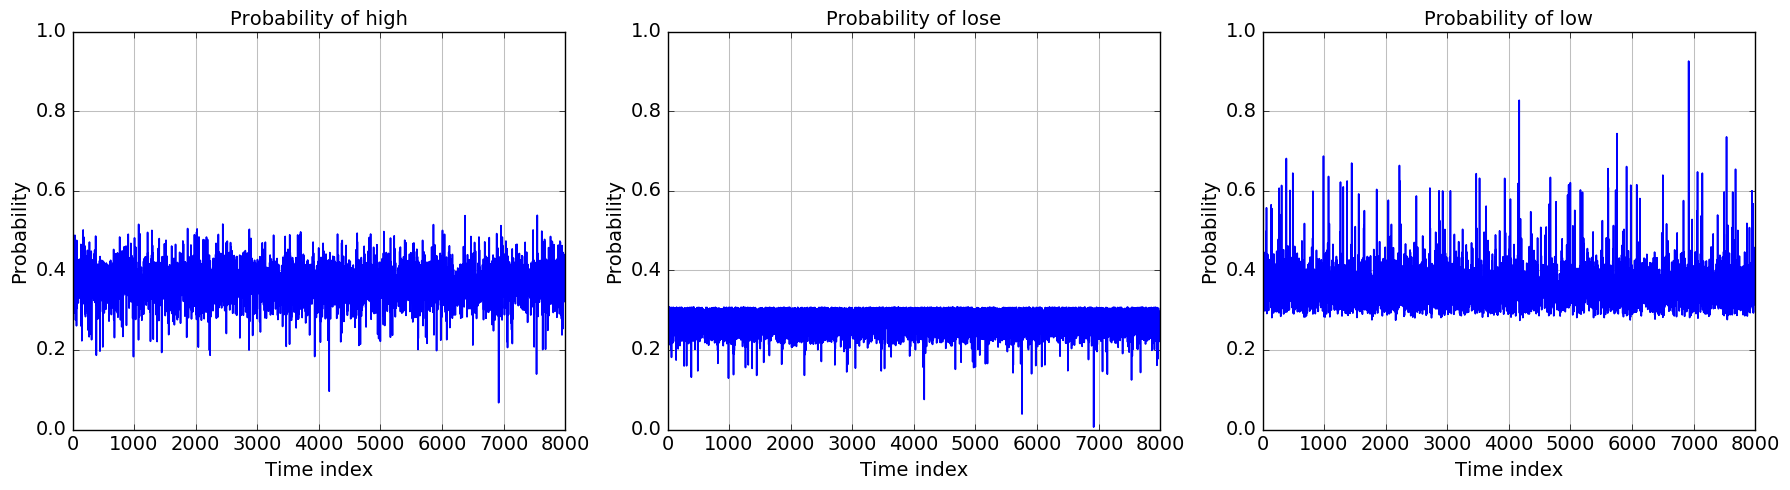

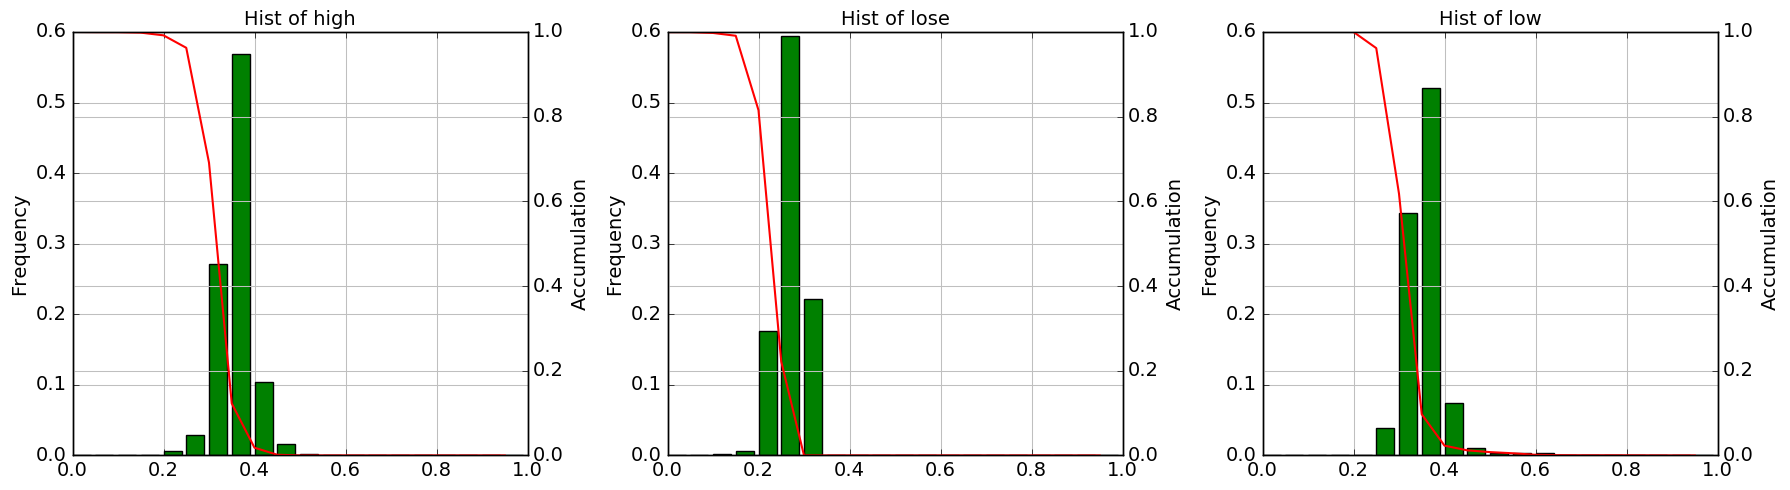

In [77]:
# 各ラベルに該当する確率
dff.makefig(18, 5)
for ii in range(len(probs)):
    plt.subplot(1,3,ii + 1)
    plt.plot(probs[ii], linewidth=1.2)
    dff.arrangefig(xlabel="Time index", ylabel="Probability", title="Probability of {}".format(labels[ii]))
    plt.ylim(0, 1)
plt.tight_layout()

# 各ラベルに該当する確率のヒストグラム
dff.makefig(18, 5)
dxbins = np.diff(xbins)[0]
for ii in range(len(hists)):
    plt.subplot(1,3,ii + 1)
    plt.bar(xbins, hists[ii], width=0.8*dxbins, hold="center", color="g")
    dff.arrangefig(ylabel="Frequency")
    ax2 = plt.gca().twinx()
    ax2.plot(xbins, 1.0 - np.cumsum(hists[ii]), "r-", linewidth=1.5)
    dff.arrangefig(xlabel="Probability", ylabel="Accumulation", title="Hist of {}".format(labels[ii]))
    plt.ylim(0, 1)
#     plt.yscale("log")
plt.tight_layout()

In [78]:
prob_threshold = 0.50
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X_test)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [13  0 96] ,total: 109 , percentage:1.4
loss= 0.83798375589
accuracy= 0.688073396136


In [92]:
prob_threshold = 0.50
probs = model.predict_proba(X, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X[ind_sum], y[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [ 52   0 312] ,total: 364 , percentage:1.4
loss= 0.805220394344
accuracy= 0.700549450549


予測に対するスレッショルドを変えたときの、勝てそうな部分と精度はつぎのようになった。   

|スレッショルド|全体に対する割合|精度|
|:---:|:---:|:---:|
|60%|0.4% / 6min|90%|
|55%|0.7% / 10min|86%|
|50%|1.4% / 20min|70%|

この感じだと、55%以上がよさそうか？

## まとめ
SMAにHLを加えると、SMAだけの場合に比べてさらに確率が上がる。   
しかしcloseのみの場合と比べて大きな差はない。   
欠損データをどうするかとか、前のデータいくつ分までを時系列データとして取り入れるかなど、いくつか検討したいことがある。   
ひとまず、何度かテストデータを変えてみて、今のモデルで確率を計算した後にバックテストに移ろうと思う。

## データの保存

In [81]:
adapter = KerasModelAdapter(model)

In [82]:
adapter.save("./data/model_20170601_2/")

In [86]:
adapter2 = KerasModelAdapter()
adapter2.load("./data/model_20170601/")

In [87]:
model2 = adapter2.model()

In [89]:
prob_threshold = 0.60
probs = model2.predict_proba(X, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X)))

# # テストデータを用いて評価する --- (※6)
score = model2.evaluate(X[ind_sum], y[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [  9   0 103] ,total: 112 , percentage:0.4
loss= 0.560678924833
accuracy= 0.875
